# Optimize something
ML for trading Udacity Course exercise

Analyze a portfolio.
https://quantsoftware.gatech.edu/Optimize_something

A transcription of the Udacity Course lectures can be find on https://docs.google.com/document/d/1ELqlnuTSdc9-MDHOkV0uvSY4RmI1eslyQlU9DgOY_jc/edit?usp=sharing

Kairoart 2018
"""


## Overview

In this project you will use what you learned about optimizers to optimize a portfolio. That means that you will find how much of a portfolio's funds should be allocated to each stock so as to optimize it's performance. We can optimize for many different metrics. In previous versions of this assignment, we tried to maximize Sharpe Ratio. We're changing it this time to define "optimal" as minimum volatility.

You will leverage the functions you created in the "asess_portfolio" project that assessed the value of a portfolio with a given set of allocations.

## Task
Implement a Python function named optimize_portfolio() that can find the optimal allocations for a given set of stocks. You should **optimize for minimum volatility** (i.e., standard deviation of daily return).

The function should accept as input a list of symbols as well as start and end dates and return a list of floats (as a one-dimensional numpy array) that represents the allocations to each of the equities. You should take advantage of routines developed in the portfolio analysis project to compute daily portfolio value and statistics. You should cut-and-paste your code for the functions that did this from the last project into optimization.py.

You are given the following inputs for optimizing a portfolio:

* A date range to select the historical data to use (specified by a start and end date)
* Symbols for equities (e.g., GOOG, AAPL, GLD, XOM). Note: You should support any symbol in the data directory.

You should implement the following API EXACTLY.

import datetime as dt
allocs, cr, adr, sddr, sr = \
    optimize_portfolio(sd=dt.datetime(2008,1,1), ed=dt.datetime(2009,1,1), \
    syms=['GOOG','AAPL','GLD','XOM'], gen_plot=False)


### Inputs

* sd: A datetime object that represents the start date
* ed: A datetime object that represents the end date
* syms: A list of symbols that make up the portfolio (note that your code should support any symbol in the data directory)
* gen_plot: If True, create a plot named plot.png

### Output

* allocs: A 1-d Numpy ndarray of allocations to the stocks. All the allocations must be between 0.0 and 1.0 and they must sum to 1.0.
* cr: Cumulative return
* adr: Average daily return
* sddr: Standard deviation of daily return
* sr: Sharpe ratio

## Goal

Your goal is to find allocations to the symbols that optimize the criteria given above. Assume 252 trading days in a year and a risk free return of 0.0 per day.

## Import libraries

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy
import os
import matplotlib.pyplot as plt
import scipy.optimize as spo
import math

# Add parent directory PATH for looking for modules,
import sys
sys.path.insert(0,'..')
from util import get_data, plot_data

## Define functions

### Find optimal allocations

* We have to provide a function to minimize f(x) that takes in x. (x = allocs)
* An initial guess for that x. 
* Call the optimizer and let it run.


In [6]:
def find_optimal_allocations(prices):

    # Number optimal allocations
    noa = len(prices.columns)
    # Using shift with positive integer shifts rows value downwards
    rets = np.log(prices / prices.shift(1))
    #print rets

    # Expected portfolio returns
    prets = [0, 0, 0, 0]
    # Expected portfolio volatility    
    pvols = [0, 0, 0, 0]
    
    # Initial guess for allocs
    for p in range (2500):
        allocs = np.random.random(noa)
        allocs /= np.sum(allocs)
        prets.append(np.sum(rets.mean() * allocs) * 252)
        pvols.append(np.sqrt(np.dot(allocs.T, np.dot(rets.cov() * 252, allocs))))
    
    
    prets = np.array(prets)
    pvols = np.array(pvols)

    def statistics(allocs):
        ''' Returns portfolio statistics.
        Parameters
        ==========
        @allocs : <array-like> weights for different securities in portfolio
        
        Returns
        =======
        @pret : <float> expected portfolio return
        @pvol : <float> expected portfolio volatility
        @pret / pvol : <float> Sharpe ratio for rf=0
        '''
        allocs = np.array(allocs)
        pret = np.sum(rets.mean() * allocs) * 252
        pvol = np.sqrt(np.dot(allocs.T, np.dot(rets.cov() * 252, allocs)))
        return np.array([pret, pvol, pret / pvol])

    # The function to be minimized.
    def min_func_volatility(allocs):   
        return -statistics(allocs)[1]
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for x in range(noa))


    # Minimizer
    min_result = spo.minimize(min_func_volatility, allocs, method='SLSQP', bounds=bnds, constraints=cons, options={'disp': True, })
    return(min_result.x)

In [9]:
# This is the function that will be tested by the autograder
# The student must update this code to properly implement the functionality
def optimize_portfolio(sd = dt.datetime(2008,1,1), ed = dt.datetime(2009,1,1), \
    syms = ['GOOG','AAPL','GLD','XOM'], sv=1000000, gen_plot=False):

    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)  # automatically adds SPY
    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later

    # Get daily portfolio value
    # 1. Normalize the prices Dataframe
    normed = pd.DataFrame(index=prices.index)
    for column in prices:
        normed[column] = prices[column].values / prices[column].iloc[0];
    #print(normed)

    # 2. Calculate alloced
    allocs = find_optimal_allocations(normed) #optimize allocations
    alloced = normed * allocs

    # 3. pos_vals = alloced * start vals Dataframe
    pos_vals = pd.DataFrame()
    for column in alloced:
        pos_vals[column] = alloced[column] * sv
    pos_vals['pos_vals'] = pos_vals.iloc[:,-4:].sum(axis=1)
    #print(pos_vals)


    # 5. port_val Series
    port_val = pd.Series(pos_vals.pos_vals)
    #print(port_val)

    # 3. Daily returns Series
    daily_rets = port_val.pct_change(1)

    # Get daily portfolio value    
    normed = prices / prices.iloc[0]
    alloced = normed * allocs
    pos_vals = alloced * sv
    pos_vals = np.sum(pos_vals,axis=1)
    port_val = pos_vals

    # Get portfolio statistics (note: std_daily_ret = volatility)
    # 1. Cumulative return
    cr = (port_val[-1] / port_val[0] -1)

    # 2. Averrage daily returns
    adr = daily_rets.mean()
    # 3. Standard deviation of daily returns
    sddr = daily_rets.std()
    # 4. Sharpe ratio
    sr = adr / sddr
    k = math.sqrt(252)
    sr = k * sr
    
    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # Normalize port_val
        x = port_val[0]
        port_val = port_val.divide(x, fill_value=1)

        # Normalize SPY
        x = prices_SPY[0]
        prices_SPY = prices_SPY.divide(x, fill_value=1)

        df_temp = pd.concat([port_val, prices_SPY], 
                             keys=['Portfolio', 'SPY'], axis=1)
        df_temp.plot()
        
    #print(df_temp)
    

    return allocs, cr, adr, sddr, sr

def test_code():
    # This code WILL NOT be tested by the auto grader
    # It is only here to help you set up and test your code

    # Define input parameters
    # Note that ALL of these values will be set to different values by
    # the autograder!
    start_date = dt.datetime(2010,1,1)
    end_date = dt.datetime(2010,12,31)
    symbols = ['GOOG', 'AAPL', 'GLD', 'XOM']


    # Assess the portfolio
    allocs, cr, adr, sddr, sr = optimize_portfolio(sd = start_date, ed = end_date,\
        syms = symbols, \
        gen_plot = True)

    # Print statistics
    print("Start Date:", start_date)
    print("End Date:", end_date)
    print("Symbols:", symbols)
    print("Optimal Allocations:", allocs)
    print("Sharpe Ratio:", sr)
    print("Volatility (stdev of daily returns):", sddr)
    print("Average Daily Return:", adr)
    print("Cumulative Return:", cr)

## Testing

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.26703973410181114
            Iterations: 5
            Function evaluations: 30
            Gradient evaluations: 5
Start Date: 2010-01-01 00:00:00
End Date: 2010-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Optimal Allocations: [4.51954861e-16 1.00000000e+00 3.71924713e-15 1.16187662e-15]
Sharpe Ratio: 1.6723331246258342
Volatility (stdev of daily returns): 0.01686804922984744
Average Daily Return: 0.0017769998107861026
Cumulative Return: 0.5071797278273094


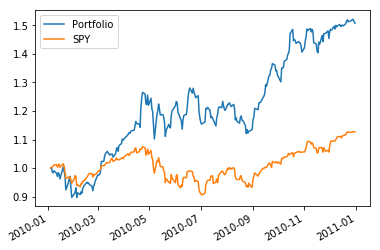

In [10]:
test_code()